In [1]:
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt
%matplotlib inline
%config IPCompleter.greedy = True

In [2]:
def linear_line(x,b0,b1):
    return b0+b1*x

def label(theta):
    return "[%2.2f,%2.2f]"%(theta[0],theta[1]);

def linearmodel(x,w):
    x = np.array(x,ndmin=2) #make sure scalars are treated as matrices
    ones = np.ones((np.shape(x)[0],1))
    phi = np.concatenate((ones,x), axis=1)
    return phi.dot(w);

### Example Data Generation

In [3]:
N = 10;
x_std = 0.1; ### data variance assumed to be known
true_beta = np.array([-0.3,0.5])
x = np.vstack(np.linspace(0,3,N))
y = np.vstack(linearmodel(x,true_beta))+np.vstack(np.random.normal(0,0.1,N)) ### x에 대한 선형결합 + 오차항

#### Draw Data

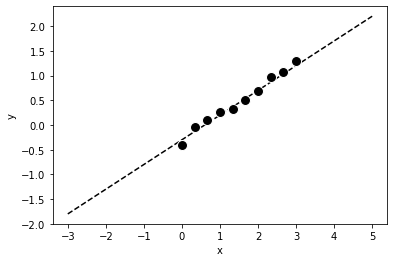

In [4]:
temp_x = np.linspace(-3,5,10)
plt.plot(temp_x, -0.3+0.5*temp_x, 'k--', label = label(true_beta.ravel()))
plt.plot(x,y,'k.',markersize = 20, label = 'data points', markeredgecolor = 'w')
plt.xlabel('x');
plt.ylabel('y');
plt.show()

### Calculate Posterior Probability Distribution

In [5]:
def likelihood(y,model,x,w,std):
    mu = model(x,w);
    ps = stats.norm.pdf(y,mu,std)
    l = 1;
    for p in ps:
        l = l*p;
    return l;

#### parameter의 space 정의
- meshgrid 함수를 사용해서 x,y의 직사각형 격자를 생성

In [6]:
#create array to cover parameter space
res = 100;
M,B = np.meshgrid(np.linspace(-1,1,res),np.linspace(-1,1,res));
MB = np.c_[M.ravel(),B.ravel()];

#### likelihood 계산
- $\sigma^{2}=1$로 data의 likelihood에 활용되는 표준편차를 이미 알고 있다고 가정

In [9]:
L = np.array([likelihood(y,linearmodel,x,mb.reshape(2,1),1) for mb in MB]).reshape(M.shape)

#### Contour Plot 그리기

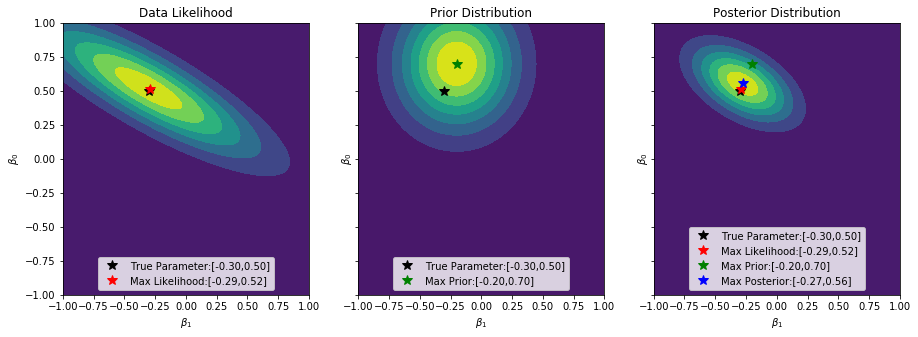

In [10]:
f, (ax2,ax3,ax4) = plt.subplots(1,3,figsize =(15,5), sharey = True)

#### Draw Likelihood function

ax2.contourf(M,B,L)
ax2.set_title('Data Likelihood')
ax2.set_xlabel(r'$\beta_1$')
ax2.set_ylabel(r'$\beta_0$')
ax2.plot(true_beta[0],true_beta[1],'k*',markersize = 10, label = 'True Parameter:' +label(true_beta))
mbMLE = MB[L.argmax()]
ax2.plot(mbMLE[0],mbMLE[1],'r*',markersize = 10, label = 'Max Likelihood:'+label(mbMLE))
ax2.legend(loc = 'lower center')

#### Prior Distribution

S0 = np.array([[0.1,0],[0.0,0.1]]) ### covariance
m0 = np.array([-0.2,0.7]) ### mean
Prior = stats.multivariate_normal.pdf(MB,m0.ravel(),S0)
Prior = Prior.reshape(M.shape)
ax3.contourf(M,B,Prior)
ax3.set_title('Prior Distribution')
ax3.set_xlabel(r'$\beta_1$')
ax3.set_ylabel(r'$\beta_0$')
ax3.plot(true_beta[0],true_beta[1],'k*',markersize = 10, label = 'True Parameter:'+label(true_beta))
ax3.plot(m0[0],m0[1],'g*',markersize = 10, label = 'Max Prior:'+label(m0))
ax3.legend(loc = 'lower center')

#### Posterior Distribution

Posterior = np.multiply(Prior,L)
ax4.contourf(M,B,Posterior)
ax4.set_title('Posterior Distribution')
ax4.set_xlabel(r'$\beta_1$')
ax4.set_ylabel(r'$\beta_0$')
mbPost = MB[Posterior.argmax()]
ax4.plot(true_beta[0],true_beta[1],'k*',markersize = 10, label = 'True Parameter:'+label(true_beta))
ax4.plot(mbMLE[0],mbMLE[1],'r*',markersize = 10, label = 'Max Likelihood:'+label(mbMLE))
ax4.plot(m0[0],m0[1],'g*',markersize = 10, label = 'Max Prior:'+label(m0))
ax4.plot(mbPost[0],mbPost[1],'b*',markersize = 10, label = 'Max Posterior:'+label(mbPost))
ax4.legend(loc = 'lower center')

### Posterior Distribution

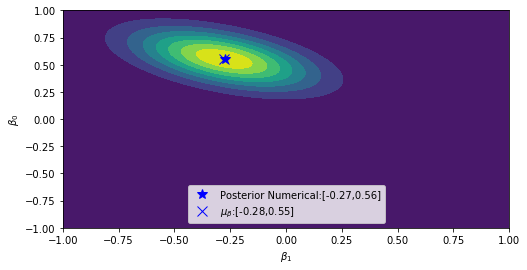

In [61]:
x = np.array(x,ndmin=2) #make sure scalars are treated as matrices
ones = np.ones((np.shape(x)[0],1))
phi = np.concatenate((ones,x), axis=1)

### Covariance Matrix ###
S_beta = np.linalg.inv(np.dot(phi.T,phi)/1 + np.linalg.inv(S0))

### mean ###
mu_beta = np.dot(S_beta,np.dot(phi.T,y)+np.vstack(np.dot(np.linalg.inv(S0),m0)))

### generate samples from normal distribution by using posterior mean and variance ###

Posterior = stats.multivariate_normal.pdf(MB,mu_beta.ravel(),S_beta)

### plot the distribution ###

plt.figure(figsize =(8,4))
plt.contourf(M,B,Posterior.reshape(M.shape))
plt.plot(mbPost[0],mbPost[1],'b*',markersize = 10, label ='Posterior Numerical:'+label(mbPost))
plt.plot(mu_beta[0],mu_beta[1],'bx',markersize = 10, label = r'$\mu_{\beta}$:'+label(mu_beta))
plt.xlabel(r'$\beta_1$')
plt.ylabel(r'$\beta_0$')
plt.legend(loc = 'lower center')

### Posterior Predictive Distribution

#### Posterior mean, covariance를 이용하여 300개의 sample 생성

In [67]:
samples = stats.multivariate_normal.rvs(mu_beta.ravel(),S_beta,300)

Text(0.5, 1.0, 'Visualization of Prediction Probability')

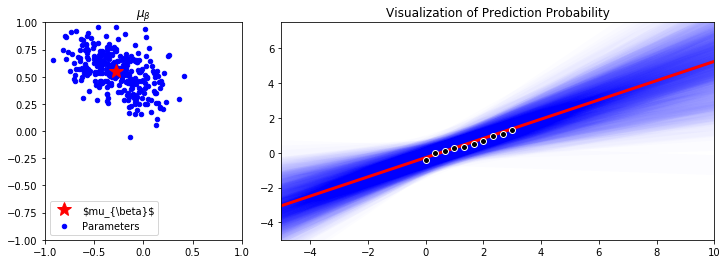

In [78]:
f = plt.figure(figsize = (12,4))
ax1 = plt.subplot2grid((1,3),(0,0), colspan = 1)
ax2 = plt.subplot2grid((1,3),(0,1), colspan = 2)

#### Plot the parameters

ax1.scatter(samples[:,0],samples[:,1], c= 'b', s = 20, label = 'Parameters')
ax1.plot(mu_beta[0],mu_beta[1],'r*',markersize = 15, label =r'\$mu_{\beta}$')
ax1.set_xlim(-1,1)
ax1.set_ylim(-1,1)
ax1.legend()
ax1.set_title(r'$\mu_{\beta}$')

#### Posterior Predictive

for sample in samples:
    temp_x = np.array([[-10],[10]])
    ax2.plot(temp_x,linearmodel(temp_x,sample),linewidth = 20, alpha = 0.01, color= 'b')

### Posterior mean 값을 이용한 직선 그리기 ###

ax2.plot(temp_x,linearmodel(temp_x,mu_beta),'r-',linewidth = 3)
ax2.plot(x,y,'ko',label = 'data points', markeredgecolor = 'w')
ax2.set_xlim(-5,10)
ax2.set_ylim(-5,7.5)
ax2.set_title('Visualization of Prediction Probability')

In [150]:
n_N = 30
n_x = np.vstack(np.hstack([np.linspace(-3,-2,10),np.linspace(0,4,10),np.linspace(6,8,10)]))
n_y = np.vstack(linearmodel(n_x,true_beta))+np.vstack(np.random.normal(0,0.1,n_N)) ### x에 대한 선형결합 + 오차항

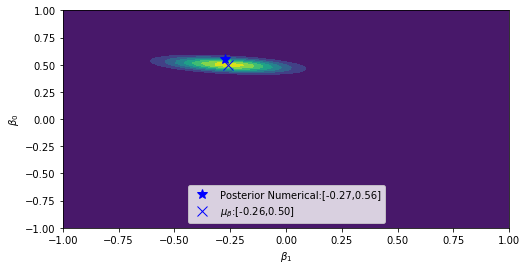

In [152]:
x = np.array(n_x,ndmin=2) #make sure scalars are treated as matrices
ones = np.ones((np.shape(n_x)[0],1))
phi = np.concatenate((ones,n_x), axis=1)

### Covariance Matrix ###
S_beta = np.linalg.inv(np.dot(phi.T,phi)/1 + np.linalg.inv(S0))

### mean ###
mu_beta = np.dot(S_beta,np.dot(phi.T,n_y)+np.vstack(np.dot(np.linalg.inv(S0),m0)))

### generate samples from normal distribution by using posterior mean and variance ###

Posterior = stats.multivariate_normal.pdf(MB,mu_beta.ravel(),S_beta)

### plot the distribution ###

plt.figure(figsize =(8,4))
plt.contourf(M,B,Posterior.reshape(M.shape))
plt.plot(mbPost[0],mbPost[1],'b*',markersize = 10, label ='Posterior Numerical:'+label(mbPost))
plt.plot(mu_beta[0],mu_beta[1],'bx',markersize = 10, label = r'$\mu_{\beta}$:'+label(mu_beta))
plt.xlabel(r'$\beta_1$')
plt.ylabel(r'$\beta_0$')
plt.legend(loc = 'lower center')

In [153]:
n_samples = stats.multivariate_normal.rvs(mu_beta.ravel(),S_beta,300)

Text(0.5, 1.0, 'Visualization of Prediction Probability')

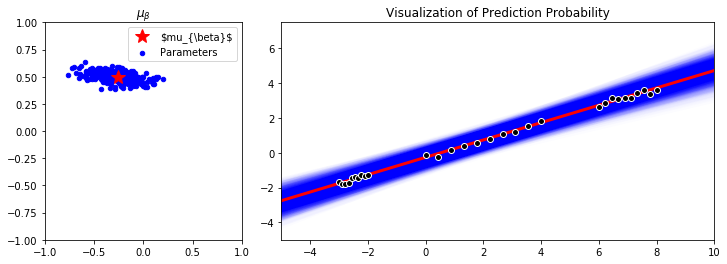

In [154]:
f = plt.figure(figsize = (12,4))
ax1 = plt.subplot2grid((1,3),(0,0), colspan = 1)
ax2 = plt.subplot2grid((1,3),(0,1), colspan = 2)

#### Plot the parameters

ax1.scatter(n_samples[:,0],n_samples[:,1], c= 'b', s = 20, label = 'Parameters')
ax1.plot(mu_beta[0],mu_beta[1],'r*',markersize = 15, label =r'\$mu_{\beta}$')
ax1.set_xlim(-1,1)
ax1.set_ylim(-1,1)
ax1.legend()
ax1.set_title(r'$\mu_{\beta}$')

#### Posterior Predictive

for sample in n_samples:
    temp_x = np.array([[-10],[10]])
    ax2.plot(temp_x,linearmodel(temp_x,sample),linewidth = 20, alpha = 0.01, color= 'b')

### Posterior mean 값을 이용한 직선 그리기 ###

ax2.plot(temp_x,linearmodel(temp_x,mu_beta),'r-',linewidth = 3)
ax2.plot(n_x,n_y,'ko',label = 'data points', markeredgecolor = 'w')
ax2.set_xlim(-5,10)
ax2.set_ylim(-5,7.5)
ax2.set_title('Visualization of Prediction Probability')